In [1]:
# SET UP (it will take a long time to run)
using Pkg; Pkg.activate("C:/Users/nicot/GitHub/Tutorial_DynMacro")
using Plots; using Optim; using Interpolations; using LinearAlgebra; using QuantEcon
Pkg.status()

  Activating environment at `C:\Users\nicot\GitHub\Tutorial_DynMacro\Project.toml`

      Status `D:\GitHub\Tutorial_DynMacro\Project.toml`
 

 [31c24e10] Distributions v0.23.11
  [2774e3e8] NLsolve v4.5.1
  [429524aa] Optim v1.4.1
  [fcd29c91] QuantEcon v0.16.2


# Basic Heterogeneous Agents Stationary Equilibrium

- Instantaneous utility function: $u(c)=\frac{c^{1-\gamma}}{1-\gamma}$
- Production: $f(K,N)=K^\alpha N^{1-\alpha}$
- Idiosincraic risk: two state markov chain (employed, unemployed)
- Borrowing limit: $ \underline{a}$
- $r_t = \alpha (N_t/K_t)^{1-\alpha}-\delta$
- Goverment charges $\tau_t$ over income $T_t=\tau(w_tN_t+r_tK_t)$
- Goverment transfers unemployments compensations $b_t$ to unemployed people $(1-N_t)$ with zero deficit $T_t=B_t$.


We can conclude that:

- At stationary equilibrium aggregate variables, prices and the asset distribution $f$ are constant
- $N_{ss}$ is determined by the stationary probability of being employed
- $r_t = \alpha (N_t/K_t)^{1-\alpha}-\delta$
- $w_t = (1-\alpha) (K_t/N_t)^\alpha$
- $b_t(N_t,K_t) = \tau(1-N_t)(w_tN_t+r_tK_t)$

Given the probabilities' transition matrix, it is possible to find the stationary probabilities, that define $N_{ss}$.

$K_{ss}$ defines $r_{ss}$ $w_{ss}$ $b_{ss}$

The household problem at the steady state (no need to include $K$ or $N$) is:

$$
V(k,\epsilon) = \max_{\underline{a} \leq a' \leq y(a,\epsilon)}
    \left\{
        u(y(a,\epsilon)-a') + \beta \; \mathbb{E}[ V(a',\epsilon')\,|\epsilon]
    \right\}
$$

Where

$$
a'|e=(1+(1-\tau)r_{ss})a+(1-\tau)w_{ss}-c:=y(a,e)-c
$$
$$
a'|u=(1+(1-\tau)r_{ss})a+b_{ss}-c:=y(a,u)-c
$$
$$
a'\geq \underline{a}
$$


Following Heer & Maussner (2009) calibration is

- $\alpha = 0.36$
- $\gamma = 2.0$
- $\beta = 0.995$
- $\delta=0.005$
- $\underline{a}^*=-2$ 
- $\tau=0.02$

$ \begin{pmatrix}
p_{ee} & p_{eu} \\
p_{ue} & p_{uu}
\end{pmatrix}=
\begin{pmatrix}
0.0435 & 0.9565 \\
0.5 & 0.5 
\end{pmatrix}
$

Although, I follow Heer & Maussner very close I will think about the borrowing limit $\underline{a}$ more carefully.
Given prices, it could happen that a houshold asset holdings are binding $a=\underline{a}^*$, and even if she doesn't consume $c=0$ she wouldn't have enough income to pay the interest of his debt (recall $\underline{a}^*<0$). So it is impossible to match both restrictions at the same time in this possible case. 

To solve that we should think as Aiyagari, and compute the natural borrowing limit for the given prices. What if someone is unemployed and he is in the borrowing limit? It has to be the case that $\underline{a}\leq \underline{a}+\underline{a}r(K)(1-\tau)+b(K)$. That implies, $\underline{a}\geq-b(K)/(r(K)(1-\tau)$.

Therefore, I redifine the stationary borrowing limit as $\underline{a}(K)=max\big\{\frac{-b(K)}{r(K)(1-\tau)}\,,\,\underline{a}^*\big\}$


In [2]:
# STEP 0: Parameters
P=[0.9565 0.0435; 0.5 0.5 ]  # 𝜖=1 empleado, 𝜖=2 desempleado
γ = 2.0
α = 0.36 
𝛿 = 0.005
β = 0.995
𝜏 = 0.02
a_minp = -2.0 # a_min parameter
rep = 0.25 # new
;

In [40]:
# STEP 1: Computing ss N and defining basic functions
mc = MarkovChain(P)
Pss=stationary_distributions(mc)[1]
@show Nss=Pss[1]

r(K) = α*(Nss/K)^(1-α)-𝛿
w(K) = (1-α)*(Nss/K)^α
b(K) = (1-Nss)*(w(K)*Nss+r(K)*K)*𝜏 # b(K) = w(K)*rep
a_min(K) = max(a_minp,-b(K)/((1-𝜏)*r(K)))
y(a,𝜖,K) = 𝜖==1 ?     a + (1-𝜏)*a*r(K) + (1-𝜏)*w(K) :  a + (1-𝜏)*a*r(K) + b(K)   # 𝜖=1 empleado, 𝜖=2 desempleado
# y(a,𝜖,K) = a + (1-𝜏)*a*r(K) + (2-𝜖)*(1-𝜏)*w(K) + (𝜖-1)*b(K)   # alternative formulation

u_crra(c) = γ==1.0 ?  log(c)  :  c^(1-γ)/(1-γ)
u(c) = c<=0.0 ?  -1.0e10  :  u_crra(c)    # to avoid problems
;

Nss = Pss[1] = 0.9199632014719411
u(0) = -1.0e10


The basic steps in the computation of the stationary distriution $f$ consists of an outer and inner loop. In the outer loop, we compute the aggregate capital stock and, hence, the factor prices and unemployment compensation. In each iteration, we find a new value of the stationary capital stock and simply update the old value by 5%. Heer & Maussner found that for higher values of the updating parameter the algorithm may not converge.

In the inner loop, we first compute the optimal policy function of the household using value function iteration. The solution provides the optimal next-period asset a' for present-period asset a and employment status e. Next, we simulate the economy for a given initial distribution of assets. We use a very simple initial distribution. Everyone holds the same (=average) wealth. Given the optimal policy function, we can compute the next-period distribution of assets and employment status. We continue to simulate the economy over a long time horizon until it converges.

Therefore we start with a first guess for $K_0$ that could be the stationary value for the representative agent problem. Then we calculate the associeted prices.

In [4]:
# STEP 2: First guess for K
@show K_0 = Nss*((α/(1/β-1+𝛿)))^(1/(1-α))

@show r_0 = r(K_0)
@show w_0 = w(K_0)
@show b_0 = b(K_0)
@show a_min_0 = a_min(K_0)

y_0(a,𝜖)=y(a,𝜖,K_0);

K_0 = Nss * (α / ((1 / β - 1) + 𝛿)) ^ (1 / (1 - α)) = 247.6225912510229
r_0 = r(K_0) = 0.005025125628140613
w_0 = w(K_0) = 0.08538328174329603
b_0 = b(K_0) = 0.002117588174361281
a_min_0 = a_min(K_0) = -0.4300000476509209


In [50]:
@show y(-2,1,K_0)
@show y_0(-2.0,1)

@show y(-2.0,2,K_0)
@show y_0(-2.0,2)

;

y(-2, 1, K_0) = -1.9261736301227255
y_0(-2.0, 1) = -1.9261736301227255
y(-2.0, 2, K_0) = -2.007731658056794
y_0(-2.0, 2) = -2.007731658056794


We need to come up with an intial guess for the value function. One natural guess is to use the values for the value function that are implied by a household behavior where he/she simply consums their current income forever. 

In [55]:
# STEP 3: Computing Household policy function

# Asset grid
a_max = 3000 # an upper limit is needed, followed Heer Maussner
n_A = 201 # points in the grid
A_grid = range(a_min_0, a_max, length=n_A)

# Initialization of the value function
V_0(a,𝜖) = u(y(a,𝜖,K_0)-a)/(1-β)                       # First guess you eat all your income, you maintain your asset holdings
V_0_mat=[V_0(a,𝜖) for a in A_grid, 𝜖 in 1:2]         # Matrix form

# Bellman's operator
function T(V, A_grid)                                                               # takes a 2 x n matrix  and a grid of n points
    V_lin(𝜖) = LinearInterpolation(A_grid, V[:,𝜖], extrapolation_bc = Line())       # linear interpolation of each row (𝜖)
    V_new=fill(0.0,(length(A_grid),2)); g_new=fill(0.0,(length(A_grid),2))          # initialize two 2 x n empty matrixes     
    for 𝜖 in 1:2
        objectives = (A -> u.(y_0(a,𝜖)-A) + β * ( P[𝜖,1] * V_lin(1)(A) + P[𝜖,2] * V_lin(2)(A) )   for a in A_grid)    # objective functions (one function for each a in the grid)
        results = maximize.(objectives, A_grid[1]+1e-10, y_0.(A_grid,𝜖).+1e-10)  # maximize every functions objective functions
        V_new[:,𝜖] = Optim.maximum.(results)                        # returns the maximum value for each function (as many functions as a-values in the grid)
        g_new[:,𝜖] = Optim.maximizer.(results)                      # returns the maximizer value for each function
    end
    return [V_new, g_new]
end



T (generic function with 1 method)

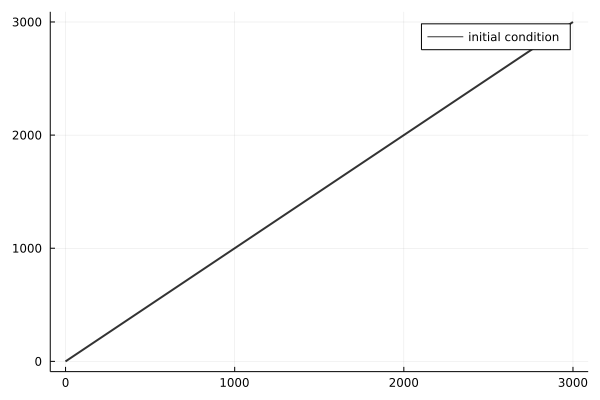

In [56]:
# Value Funvtion Iteration

V_mat = V_0_mat
g_mat = [a for a in A_grid, 𝜖 in 1:2]; # first-guess of policy function, you maintain your asset holdings

pltV=plot(A_grid, V_mat[:,1], color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")
pltg=plot(A_grid, g_mat[:,1], color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")

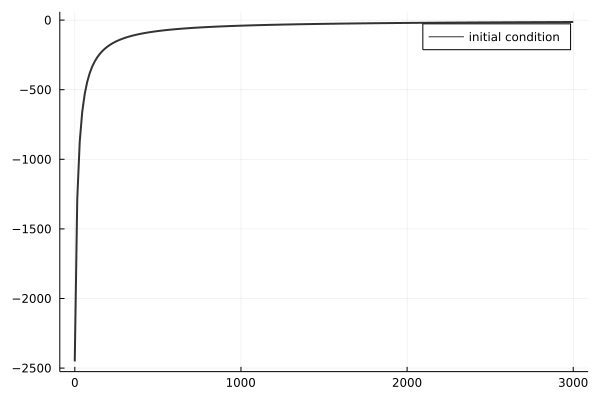

In [43]:
pltV

Number of iterations: 10
Distance between last two value functions: 5.191160203017578e8


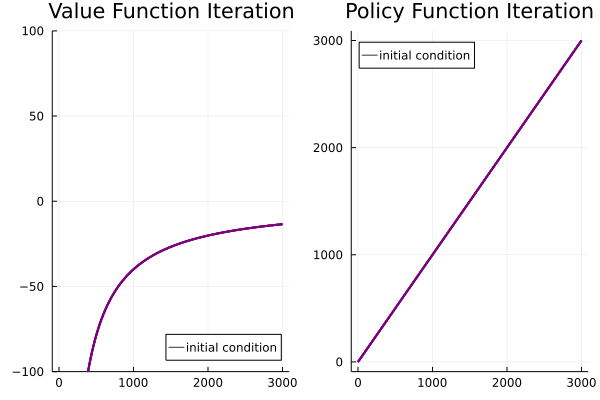

In [63]:
max_iter = 10   
tol = 0.001 # tolerance, if distance is below that I'm fine
distance=tol+1 # some initial condition for distance

i=1
while i < max_iter && distance > tol
    global V_new, g_new = T(V_mat, A_grid) # apply Bellman's operator
    if mod(i,5)==0
        plot!(pltV,A_grid, V_new[:,1], color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
        plot!(pltg,A_grid, g_new[:,1], color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    end
    distance = norm(V_new - V_mat, Inf) # measure distance. Are they close enough?
    i += 1
    V_mat = V_new
end
g_fun(𝜖)=LinearInterpolation(A_grid, g_new[:,𝜖], extrapolation_bc = Line()) # policy function K_t => K_t+1

println("Number of iterations: ",i,"\nDistance between last two value functions: ",distance)

plot!(pltV, legend = :bottomright, title="Value Function Iteration",ylim=(-100,100))
plot!(pltg, legend = :topleft, title="Policy Function Iteration")
plot(pltV, pltg)

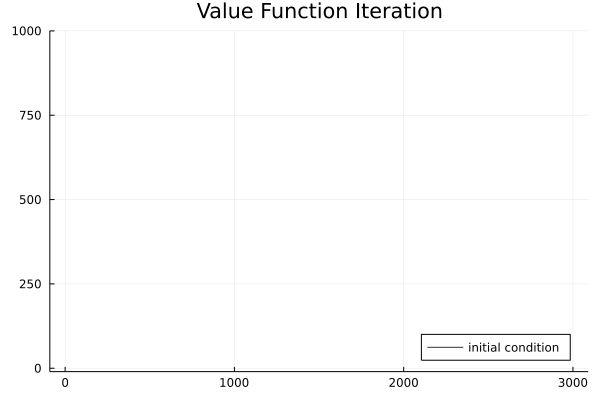

In [61]:
plot!(pltV, legend = :bottomright, title="Value Function Iteration",ylim=(-10,1000))


In [50]:
g_0_mat = [a for a in A_grid, 𝜖 in 1:2]; # first-guess of policy function, you maintain your asset holdings

pltV=plot(A_grid, V_0_mat[:,1], color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")
pltg=plot(A_grid, g_0_mat[:,1], color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")

V_1_mat, g_1_mat = T(V_0_mat, A_grid)

2-element Vector{Matrix{Float64}}:
 [-8.609455032578781e10 -1.0050000012199894e12; -1348.1657728199302 -2000.4419963367693; … ; -13.531689655064785 -13.566149107451547; -13.464386432772427 -13.49850309062149]
 [-0.34845518574396794 -0.4300000476509209; 14.572149975625022 14.572150007493379; … ; 2984.888720122876 2984.8449159524007; 2999.8901263394796 2999.8463269064796]

In [25]:
[V_1_mat[:,2]  V_0_mat[:,2] ] 

201×2 Matrix{Float64}:
   -Inf        -Inf
   -Inf      -2707.09
 -1114.05    -1353.55
  -781.607    -902.365
  -603.95     -676.774
  -492.705    -541.419
  -416.302    -451.182
  -360.519    -386.728
  -317.973    -338.387
  -284.439    -300.788
  -257.32     -270.709
  -234.933    -246.1
  -216.136    -225.591
     ⋮       
   -14.2819    -14.3233
   -14.2069    -14.2479
   -14.1327    -14.1733
   -14.0593    -14.0995
   -13.9867    -14.0264
   -13.9148    -13.9541
   -13.8437    -13.8825
   -13.7732    -13.8117
   -13.7035    -13.7416
   -13.6345    -13.6722
   -13.5661    -13.6035
   -13.4985    -13.5355

In [45]:
norm(V_1_mat[:,2]-V_0_mat[:,2])

9.949999987800089e11

In [30]:
norm([-13.4985]-[-13.5355])

0.03700000000000081

In [31]:
norm([-Inf]-[-2707.09])

Inf

In [32]:
norm([-Inf]-[-Inf])

NaN

In [33]:
Inf-Inf

NaN

In [34]:
norm(NaN)

NaN

In [39]:
maximum(abs.([NaN; 2.0]))

NaN

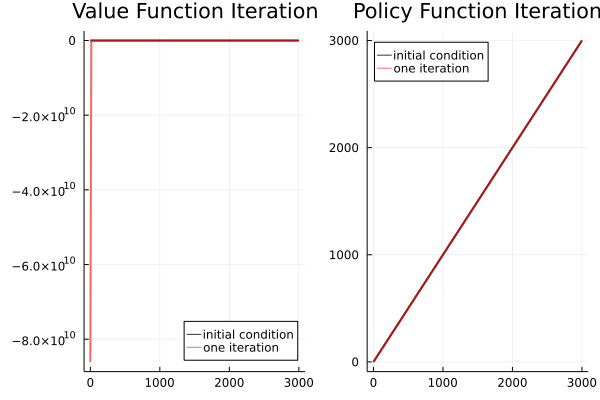

In [51]:
plot!(pltV,A_grid, V_1_mat[:,1], color = RGBA(1, 0, 0, 0.8), linewidth = 2, alpha = 0.6, label = "one iteration")
plot!(pltg,A_grid, g_1_mat[:,1], color = RGBA(1, 0, 0, 0.8), linewidth = 2, alpha = 0.6, label = "one iteration")
plot!(pltV, legend = :bottomright, title="Value Function Iteration")
plot!(pltg, legend = :topleft, title="Policy Function Iteration")
plot(pltV, pltg)

In [14]:
distance = norm(V_1_mat - V_0_mat)

NaN